# Projekt Zespołowy - Zastosowanie oraz porównanie istniejących architektur do klasyfikacji obrazów na przykładzie CIFAR-10

## Wstęp

### Cel

Celem projektu jest omówienie oraz porównanie wybranych modeli uczenia maszynowego do klasyfiakcji obrazów na przykładzie zbioru CIFAR-10.

### Dataset

CiFar-10 to zbiór danych, który składa się z 60000 kolorowych obrazów o rozmiarze 32x32 pikseli, podzielonych na 10 klas. Każda klasa zawiera 6000 obrazów. Zbiór ten zawiera 50000 obrazów treningowych oraz 10000 obrazów testowych.

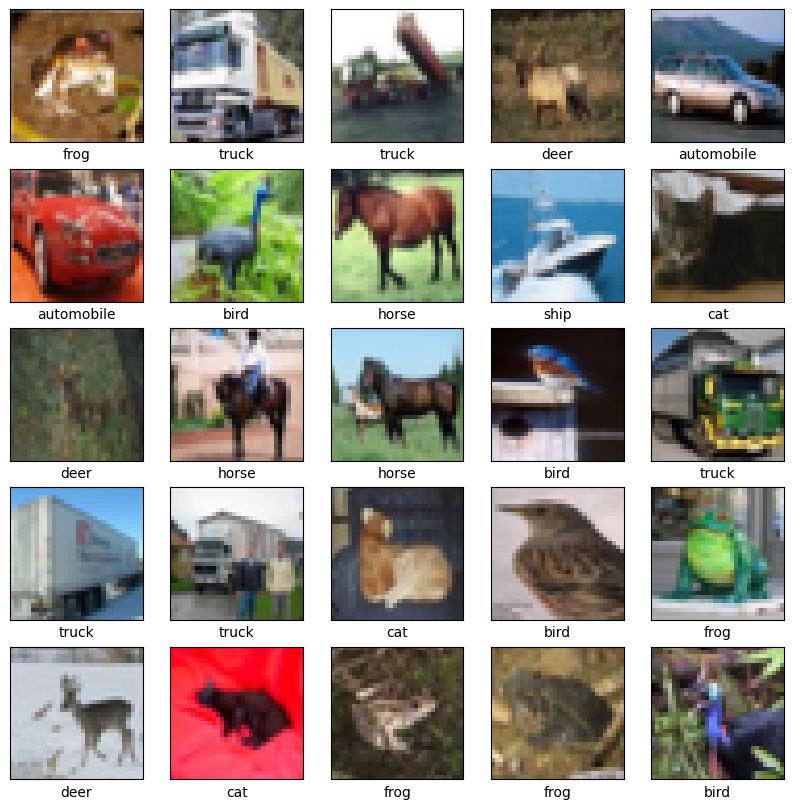

In [3]:
# Import oraz demonstracja danych
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Etkiety klas
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Wyświetlenie przykładowych obrazów
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(class_names[y_train[i][0]])
plt.show()


Wszystkich klas jest po równo, co oznacza, że zbiór jest zbalansowany:

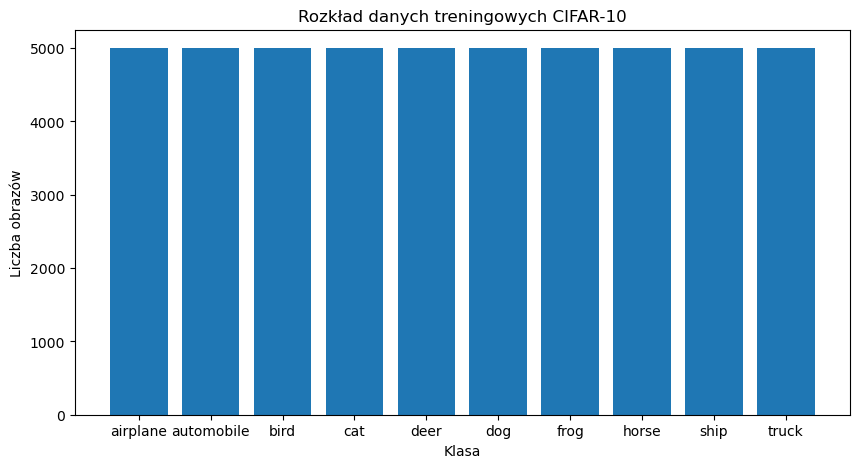

In [3]:
# Analiza rozkładu danych treningowych
unique, counts = np.unique(y_train, return_counts=True)
class_counts = dict(zip(unique, counts))

# Wyświetlenie rozkładu klas
plt.figure(figsize=(10, 5))
plt.bar(class_names, counts)
plt.xlabel('Klasa')
plt.ylabel('Liczba obrazów')
plt.title('Rozkład danych treningowych CIFAR-10')
plt.show()


### Wyniki modeli SOTA w porównaniu z ludźmi

![Przykładowe wyniki](images/przykladowe_wyniki.png)

<font size="3"><i>Ho-Phuoc, T. (Year). CIFAR10 to Compare Visual Recognition Performance between Deep Neural Networks and Humans. The University of Danang – University of Science and Technology.<font><i>

Jak widać, modele widzenia komputerowego "State Of The Art" oparte na sieciach neuronowych od kilku lat osigają wyniki przewyższające ludzkie.

## Uczenie płytkie

### Regresja logistyczna 

Regresja logistyczna jest w pewnym sensie rozszerzeniem regresji liniowej. Podobnie jak w regresji liniowej, obliczamy ważoną sumę cech wejściowyc, lecz dodatkowo przekształcamy wynik za pomocą funkcji logistycznej (odpowiednik prawdopodobieństwa), która zwraca wartości z przedziału [0, 1]:

![Regresja logistyczna 1](images/logreg1.png)

![Regresja logistyczna 2](images/logreg2.png)

<font size="3"><i>Obrazki pochodzą z książki _"Uczenie maszynowe z wykorzystaniem Scikit-Learn, Keras i TensorFlow"_ autorstwa Aurélien Géron.</i></font>

Tym razem funkcję kosztu definiujemy w ten sposób, żeby model zwracał prawdopodobieństwa bliskie 1 dla obserwacji z klasy 1 oraz bliskie 0 dla obserwacji z klasy 0:

![Regresja logistyczna 3](images/logreg3.png)

![Regresja logistyczna 4](images/logreg4.png)

Niestety w odróżnieniu od regresji liniowej nie ma rozwiązania analitycznego, więc musimy posłużyć się metodami optymalizacji numerycznej, np. metodą gradientową. Dobrą wiadomością jest to, że funkcja kosztu jest wypukła, więc nie ma problemu z lokalnymi minimami.

Żeby użyć regresji logistycznej do klasyfikacji wieloklasowej, możemy posłużyć się metodą One-vs-All, czyli trenujemy tyle modeli binarnych, ile mamy klas (każdy model będzie szacował prowdopodobieństwo prznależności do pojedyńczej klasy), a następnie wybieramy klasę z najwyższym prawdopodobieństwem.

Jeszcze lepszym rozwiązaniem jest użycie metody Softmax, która pozwala na oszacowanie prawdopodobieństwa przynależności do każdej z klas jednocześnie. W tym przypadku przypisujemy każdej klasie swój wektor wag, a wynik przekształcamy za pomocą funkcji softmax ($\hat{p}_k$
to prawdopodobieństwo przynależności próbki do klasy k):

![Regresja logistyczna 5](images/logreg5.png)

Po zastosowaniu tak wybranego klasyfikatora, otrzymujemy następującą funkcję kosztu (inaczej entropia krzyżowa):

![Regresja logistyczna 6](images/logreg6.png)

Użyjemy regresji logistycznej Softmax do klasyfikacji obrazów z CIFAR-10. W tym celu najpierw przeskalujemy dane, a następnie podzielimy zbiór danych na zbiór treningowy i testowy. Potem zdefiniujemy model regresji logistycznej, skompilujemy go oraz wytrenujemy. Na końcu ocenimy jakość modelu.

Epoch 1/10
1250/1250 [==============================] - 1s 996us/step - loss: 1.9622 - accuracy: 0.2977 - val_loss: 1.8676 - val_accuracy: 0.3480
Epoch 2/10
1250/1250 [==============================] - 1s 885us/step - loss: 1.8514 - accuracy: 0.3479 - val_loss: 1.8810 - val_accuracy: 0.3352
Epoch 3/10
1250/1250 [==============================] - 1s 903us/step - loss: 1.8200 - accuracy: 0.3620 - val_loss: 1.8703 - val_accuracy: 0.3470
Epoch 4/10
1250/1250 [==============================] - 1s 919us/step - loss: 1.7973 - accuracy: 0.3696 - val_loss: 1.8256 - val_accuracy: 0.3645
Epoch 5/10
1250/1250 [==============================] - 1s 921us/step - loss: 1.7832 - accuracy: 0.3791 - val_loss: 1.8148 - val_accuracy: 0.3653
Epoch 6/10
1250/1250 [==============================] - 1s 932us/step - loss: 1.7728 - accuracy: 0.3816 - val_loss: 1.8065 - val_accuracy: 0.3679
Epoch 7/10
1250/1250 [==============================] - 1s 932us/step - loss: 1.7671 - accuracy: 0.3835 - val_loss: 1.7931 -

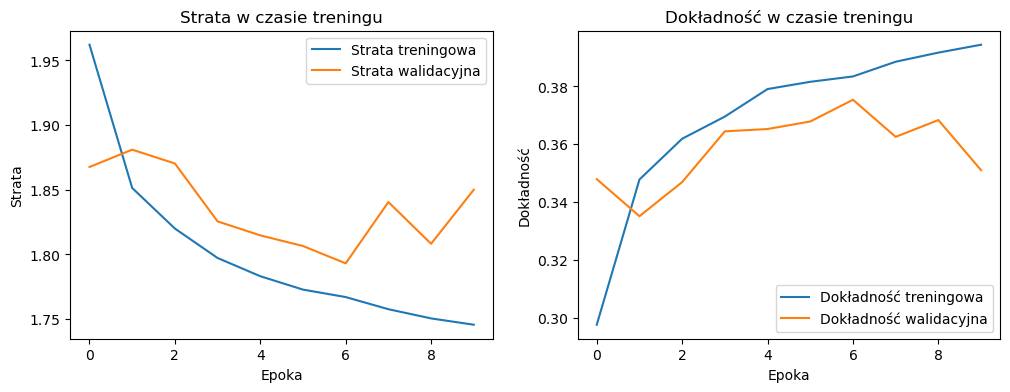

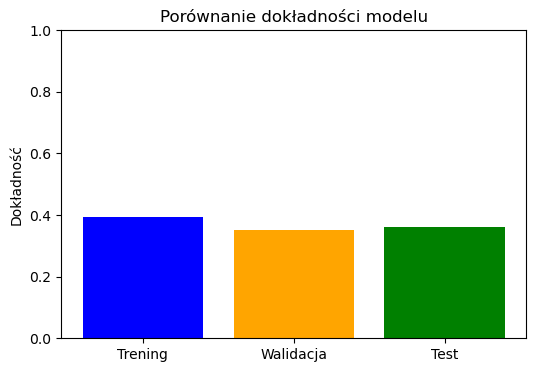

In [5]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt

# Załaduj dane CIFAR-10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Przeskaluj dane
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# One-hot encoding etykiet
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Zdefiniuj model regresji logistycznej Softmax
model = Sequential([
    Flatten(input_shape=(32, 32, 3)),
    Dense(10, activation='softmax')
])

# Skompiluj model
model.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['accuracy'])

# Wytrenuj model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Oceń model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

# Wykresy
# Wykres straty
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Strata treningowa')
plt.plot(history.history['val_loss'], label='Strata walidacyjna')
plt.title('Strata w czasie treningu')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.legend()

# Wykres dokładności
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Dokładność treningowa')
plt.plot(history.history['val_accuracy'], label='Dokładność walidacyjna')
plt.title('Dokładność w czasie treningu')
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.legend()

plt.show()

# Wykres porównania dokładności modelu na zbiorze treningowym i testowym
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]

plt.figure(figsize=(6, 4))
plt.bar(['Trening', 'Walidacja', 'Test'], [train_acc, val_acc, test_acc], color=['blue', 'orange', 'green'])
plt.title('Porównanie dokładności modelu')
plt.ylabel('Dokładność')
plt.ylim(0, 1)
plt.show()


Natychmiast udało się osiągnąć prawie 40% dokładności. Spróbujemy jeszcze polepszyć wynik za pomocą regularyzacji oraz optymalizacji hiperparametrów. Regularyzacja polega na dodaniu do funkcji kosztu kary za duże wagi, co pozwala na uniknięcie overfittingu. Optymalizacja hiperparametrów polega na znalezieniu takich wartości hiperparametrów (np. learning rate, batch size, liczba epok), które pozwolą na uzyskanie najlepszego wyniku.

Teraz wykorzystamy do zdefiniowania modelu bibliotekę PyTorch, ponieważ dużo szybciej będzie uruchamiać się na GPU (TensorFlow słabo obsługuje GPU na Windows).

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Training with parameters: batch_size=32, lr=0.001, l2=0.001
Training with parameters: batch_size=32, lr=0.01, l2=0.001
Training with parameters: batch_size=32, lr=0.001, l2=0.01
Training with parameters: batch_size=32, lr=0.01, l2=0.01
Training with parameters: batch_size=1024, lr=0.001, l2=0.001
Training with parameters: batch_size=1024, lr=0.01, l2=0.001
Training with parameters: batch_size=1024, lr=0.001, l2=0.01
Training with parameters: batch_size=1024, lr=0.01, l2=0.01
Best accuracy: 0.4103
Best parameters: {'batch_size': 1024, 'l2_regularization': 0.01, 'learning_rate': 0.001}


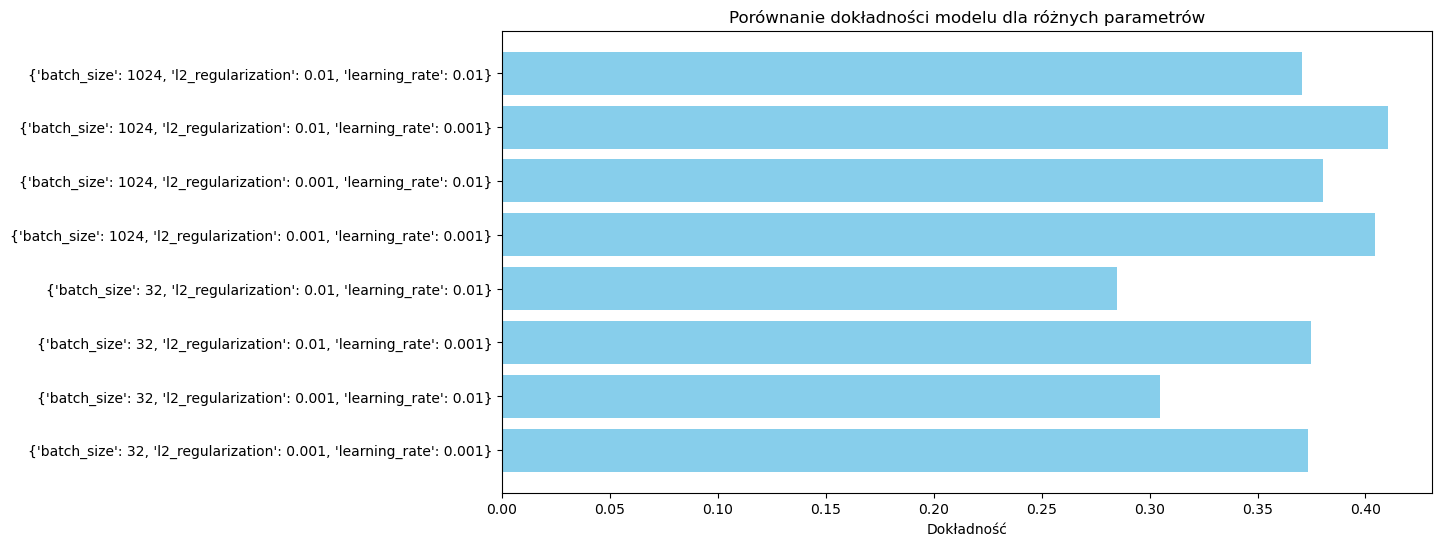

In [20]:
import os
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from accelerate import Accelerator
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt

# Użyj acceleratora
accelerator = Accelerator()

# Włącz tryb benchmark w cuDNN dla optymalnej wydajności
torch.backends.cudnn.benchmark = True

# Sprawdź urządzenie używane przez accelerator
print(f"Using device: {accelerator.device}")

# Definiuj transformacje dla zbioru danych CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Przygotuj zbiór danych CIFAR-10
train_dataset = datasets.CIFAR10(os.getcwd(), train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(os.getcwd(), train=False, download=True, transform=transform)

# Funkcja do tworzenia DataLoader
def create_dataloader(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, persistent_workers=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True, persistent_workers=True)
    return train_loader, test_loader

# Definiuj model regresji Softmax
class SoftmaxRegression(nn.Module):
    def __init__(self):
        super(SoftmaxRegression, self).__init__()
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(32*32*3, 10)
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.fc(x)
        return x

# Funkcja do trenowania modelu
def train_model(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        current_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, targets = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            accelerator.backward(loss)
            optimizer.step()
            current_loss += loss.item()

# Funkcja do testowania modelu
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Hiperparametry do optymalizacji
param_grid = {
    'batch_size': [32, 1024], 
    'learning_rate': [0.001, 0.01],
    'l2_regularization': [0.001, 0.01]
}

# Stała liczba epok
epochs = 10

# Optymalizuj hiperparametry
best_acc = 0
best_params = None
results = []

for params in ParameterGrid(param_grid):
    param_set = f"batch_size={params['batch_size']}, lr={params['learning_rate']}, l2={params['l2_regularization']}"
    print(f"Training with parameters: {param_set}")
    
    train_loader, test_loader = create_dataloader(params['batch_size'])
    
    model = SoftmaxRegression()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['l2_regularization'])
    
    # Przygotuj z accelerator
    model, optimizer, train_loader, test_loader = accelerator.prepare(model, optimizer, train_loader, test_loader)
    
    train_model(model, train_loader, criterion, optimizer, epochs)
    acc = test_model(model, test_loader)
    
    results.append({
        'params': params,
        'final_accuracy': acc
    })
    
    if acc > best_acc:
        best_acc = acc
        best_params = params

    # Oczyść DataLoader aby zwolnić pamięć
    del train_loader
    del test_loader
    torch.cuda.empty_cache()  # Opróżnij pamięć GPU

print(f'Best accuracy: {best_acc}')
print(f'Best parameters: {best_params}')

# Wykres porównania dokładności modelu dla różnych parametrów
params_list = [str(result['params']) for result in results]
final_accuracies = [result['final_accuracy'] for result in results]

plt.figure(figsize=(12, 6))
plt.barh(params_list, final_accuracies, color='skyblue')
plt.xlabel('Dokładność')
plt.title('Porównanie dokładności modelu dla różnych parametrów')
plt.show()


Jak widać, bardziej optymalnym zestawem parametrów jest {'batch_size': 1024, 'l2_regularization': 0.01, 'learning_rate': 0.001}, lecz, mimo że udało nam się przekroczyć 40%, dokładność modelu pozostała na bardzo zbliżonym poziomie. Jak widać regresja nie pasuje do tego problemu, ponieważ nie jest w stanie wyodrębnić cech obrazów. Spróbujemy teraz zastosować inne modele.

### Drzewa decyzyjne

### Lasy losowe

### Maszyny Wektorów Nośnych

### KNN alorithm

## Uczenie głębokie

### MLP perceptron

### Sieć neuronowa

### CNN – Konwolucyjna sieć neuronowa od zera

Konwolucyjne sieci neuronowe (CNN) są jednym z najpopularniejszych modeli do klasyfikacji obrazów. Składają się z warstw konwolucyjnych, warstw poolingowych oraz warstw w pełni połączonych. Warstwy konwolucyjne służą do wykrywania cech w obrazie, warstwy poolingowe do zmniejszania wymiarowości obrazu, a warstwy w pełni połączone do klasyfikacji. Ta architektura była zainspirowana budową kory wzrokowej człowieka.

![KNN1](images/knn1.png)

W naszym przypadku zbudujemy prostą sieć z jedną warstwą konwolucyjną, jedną warstwą poolingową oraz jedną warstwą w pełni połączoną. Na końcu dodamy funkcję aktywacji Softmax, która zwróci prawdopodobieństwa przynależności do każdej z klas.

Następnie spróbujemy dodać więcej warstw i porównamy wyniki.

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
[simple_cnn] Epoch [1/10] Loss: 1.4374, Val Accuracy: 0.5585
[simple_cnn] Epoch [2/10] Loss: 1.1640, Val Accuracy: 0.5912
[simple_cnn] Epoch [3/10] Loss: 1.0450, Val Accuracy: 0.6190
[simple_cnn] Epoch [4/10] Loss: 0.9616, Val Accuracy: 0.6302
[simple_cnn] Epoch [5/10] Loss: 0.9054, Val Accuracy: 0.6358
[simple_cnn] Epoch [6/10] Loss: 0.8595, Val Accuracy: 0.6423
[simple_cnn] Epoch [7/10] Loss: 0.8220, Val Accuracy: 0.6373
[simple_cnn] Epoch [8/10] Loss: 0.7915, Val Accuracy: 0.6376
[simple_cnn] Epoch [9/10] Loss: 0.7608, Val Accuracy: 0.6475
[simple_cnn] Epoch [10/10] Loss: 0.7325, Val Accuracy: 0.6484
Accuracy of the simple CNN on the test images: 64.73%


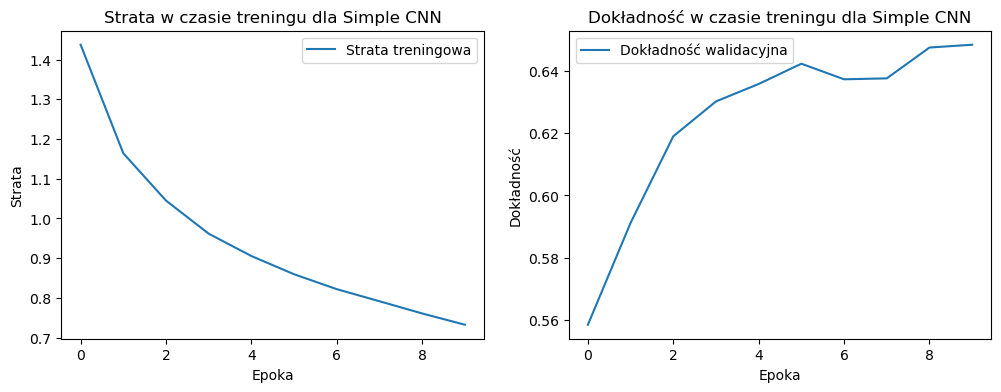

In [30]:
import os
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from accelerate import Accelerator
import matplotlib.pyplot as plt

# Użyj acceleratora
accelerator = Accelerator()

# Włącz tryb benchmark w cuDNN dla optymalnej wydajności
torch.backends.cudnn.benchmark = True

# Sprawdź urządzenie używane przez accelerator
print(f"Using device: {accelerator.device}")

# Definiuj transformacje dla zbioru danych CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Przygotuj zbiór danych CIFAR-10
dataset = datasets.CIFAR10(os.getcwd(), train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(os.getcwd(), train=False, download=True, transform=transform)

# Podziel zbiór danych na treningowy i walidacyjny
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Funkcja do tworzenia DataLoader
def create_dataloader(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, persistent_workers=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True, persistent_workers=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True, persistent_workers=True)
    return train_loader, val_loader, test_loader

# Definiuj prostą sieć CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(32 * 16 * 16, 10)
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(-1, 32 * 16 * 16)
        x = self.fc1(x)
        return x

# Funkcja do trenowania modelu
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, param_set, train_losses, val_accuracies):
    model.train()
    for epoch in range(epochs):
        current_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, targets = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            accelerator.backward(loss)
            optimizer.step()
            current_loss += loss.item()
        train_losses.append(current_loss / len(train_loader))
        val_acc = validate_model(model, val_loader)
        val_accuracies.append(val_acc)
        print(f'[{param_set}] Epoch [{epoch + 1}/{epochs}] Loss: {current_loss / len(train_loader):.4f}, Val Accuracy: {val_acc:.4f}')

# Funkcja do walidacji modelu
def validate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Funkcja do testowania modelu
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Hiperparametry
batch_size = 64
learning_rate = 0.001
epochs = 10

# Inicjalizuj model
train_loader, val_loader, test_loader = create_dataloader(batch_size)
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Przygotuj z accelerator
model, optimizer, train_loader, val_loader, test_loader = accelerator.prepare(model, optimizer, train_loader, val_loader, test_loader)

train_losses = []
val_accuracies = []

# Trenuj model
train_model(model, train_loader, val_loader, criterion, optimizer, epochs, "simple_cnn", train_losses, val_accuracies)

# Oceń model
accuracy = test_model(model, test_loader)
print(f'Accuracy of the simple CNN on the test images: {accuracy * 100:.2f}%')

# Wizualizacja wyników
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Strata treningowa')
plt.title('Strata w czasie treningu dla Simple CNN')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Dokładność walidacyjna')
plt.title('Dokładność w czasie treningu dla Simple CNN')
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.legend()

plt.show()


Widać, że ten model ma duży potencjał - nawet w podstawowej wersji osiągnął wynik 65% dokładności. Spróbujemy teraz zbudować bardziej zaawansowany model.

[extended_cnn] Epoch [1/10] Loss: 1.4154, Val Accuracy: 0.5997
[extended_cnn] Epoch [2/10] Loss: 0.9591, Val Accuracy: 0.6758
[extended_cnn] Epoch [3/10] Loss: 0.7687, Val Accuracy: 0.7047
[extended_cnn] Epoch [4/10] Loss: 0.6043, Val Accuracy: 0.7136
[extended_cnn] Epoch [5/10] Loss: 0.4460, Val Accuracy: 0.7192
[extended_cnn] Epoch [6/10] Loss: 0.2942, Val Accuracy: 0.7318
[extended_cnn] Epoch [7/10] Loss: 0.1803, Val Accuracy: 0.7197
[extended_cnn] Epoch [8/10] Loss: 0.0999, Val Accuracy: 0.7269
[extended_cnn] Epoch [9/10] Loss: 0.0751, Val Accuracy: 0.7247
[extended_cnn] Epoch [10/10] Loss: 0.0714, Val Accuracy: 0.7217
Accuracy of the extended CNN on the test images: 71.80%


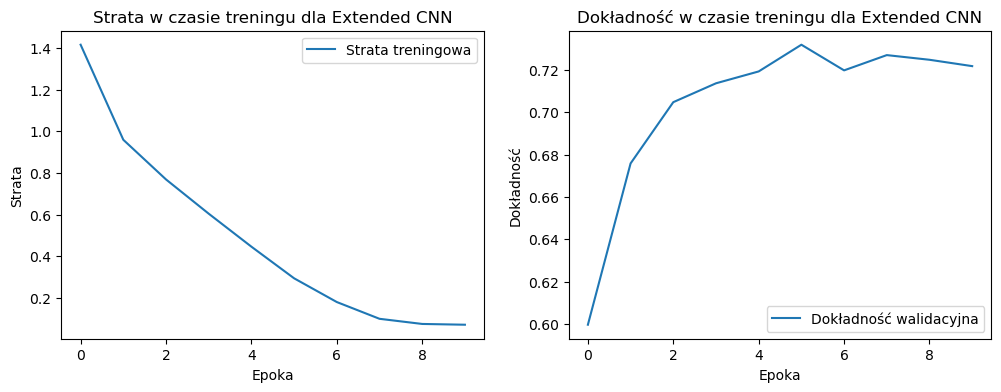

In [19]:
# Definiuj rozszerzoną sieć CNN
class ExtendedCNN(nn.Module):
    def __init__(self):
        super(ExtendedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Hiperparametry
batch_size = 64
learning_rate = 0.001
epochs = 10

# Inicjalizuj model
train_loader, val_loader, test_loader = create_dataloader(batch_size)
model = ExtendedCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Przygotuj z accelerator
model, optimizer, train_loader, val_loader, test_loader = accelerator.prepare(model, optimizer, train_loader, val_loader, test_loader)

train_losses = []
val_accuracies = []

# Trenuj model
train_model(model, train_loader, val_loader, criterion, optimizer, epochs, "extended_cnn", train_losses, val_accuracies)

# Oceń model
accuracy = test_model(model, test_loader)
print(f'Accuracy of the extended CNN on the test images: {accuracy * 100:.2f}%')

# Wizualizacja wyników
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Strata treningowa')
plt.title('Strata w czasie treningu dla Extended CNN')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Dokładność walidacyjna')
plt.title('Dokładność w czasie treningu dla Extended CNN')
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.legend()

plt.show()


Teraz stało się oczywiste czemu architektura CNN stała się przedmiotem intensywnych badań w dziedzinie widzenia komputerowego. Bez zbytnich komplikacji udało się osiągnąć wynik 72% dokładności. Okazuje się, że przy wystarczająco dużej ilości warstw oraz odpowiednich hiperparametrach, CNN potrafi osiągnąć wyniki porównywalne z ludźmi. Jeszce lepsze wyniki wykazuje modyfikacja CNN, czyli sieć ResNet (sieć rezydualna).

## Modele SOTA (State Of The Art) 

### ResNet


Sieci rezydualne (ResNet) to rodzina sieci neuronowych, które pozwalają na trenowanie bardzo głębokich modeli. W przeciwieństwie do zwykłych sieci neuronowych, w których informacje przepływają sekwencyjnie, w ResNet informacje przepływają za pomocą skoków z jednej warstwy do innej. Dzięki temu unikamy problemu zanikającego gradientu, który pojawia się w bardzo głębokich sieciach.

![ResNet](images/resnet1.png)

Zastosujemy model ResNet50, który składa się z 50 warstw. Wytrenujemy go na zbiorze CIFAR-10 (tzw. fine-tuning, kiedy zmieniane są tylko ostatnie warstwy) i porównamy wyniki z poprzednimi modelami.



Files already downloaded and verified
Files already downloaded and verified
Epoch [1/10] Loss: 0.6224, Val Accuracy: 0.8856
Epoch [2/10] Loss: 0.2986, Val Accuracy: 0.8828
Epoch [3/10] Loss: 0.1516, Val Accuracy: 0.8767
Early stopping
Zapisano wytrenowany model.


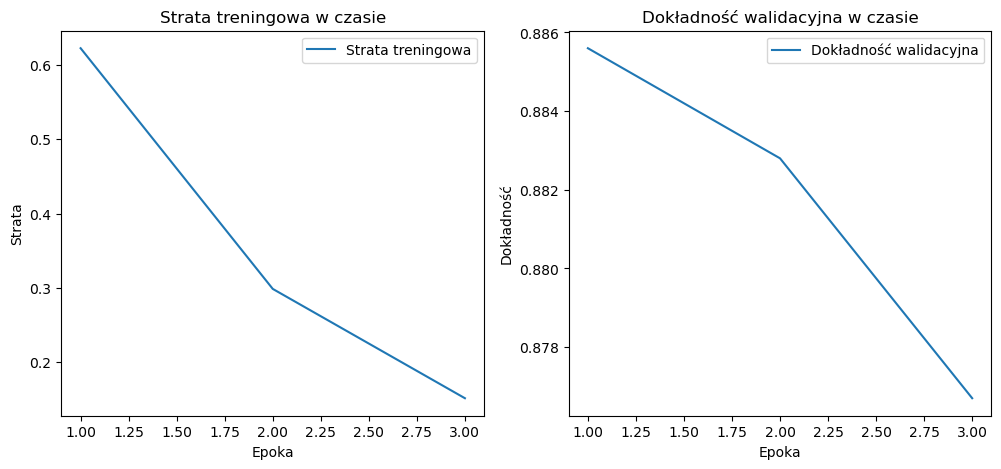

Accuracy of fine-tuned ResNet on the test images: 87.48%


In [40]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import timm
from accelerate import Accelerator
import matplotlib.pyplot as plt

# Inicjalizuj accelerator
accelerator = Accelerator()

# Definiuj transformacje dla zbioru danych CIFAR-10
transform = transforms.Compose([
    transforms.Resize(224),  # Zmień rozmiar, aby dopasować do wejścia modelu
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Przygotuj zbiór danych CIFAR-10
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Podziel zbiór danych na treningowy i walidacyjny
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Funkcja do tworzenia DataLoader
def create_dataloader(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, persistent_workers=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True, persistent_workers=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True, persistent_workers=True)
    return train_loader, val_loader, test_loader

# Załaduj wstępnie wytrenowany model ResNet z timm i zmodyfikuj go dla CIFAR-10
model = timm.create_model('resnet50', pretrained=True, num_classes=10)

# Zamroź początkowe warstwy
for name, param in model.named_parameters():
    if "layer4" not in name:  # Odblojuj tylko ostatni blok
        param.requires_grad = False

# Definiuj funkcję straty i optymalizator
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

# Stwórz DataLoader'y
batch_size = 64
train_loader, val_loader, test_loader = create_dataloader(batch_size)

# Przygotuj z accelerator
model, optimizer, train_loader, val_loader, test_loader = accelerator.prepare(model, optimizer, train_loader, val_loader, test_loader)

# Funkcja do trenowania modelu z wczesnym zatrzymaniem
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, patience):
    model.train()
    train_losses = []
    val_accuracies = []
    best_val_accuracy = 0
    patience_counter = 0

    for epoch in range(epochs):
        current_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, targets = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            accelerator.backward(loss)
            optimizer.step()
            current_loss += loss.item()
        
        avg_loss = current_loss / len(train_loader)
        train_losses.append(avg_loss)
        val_acc = validate_model(model, val_loader)
        val_accuracies.append(val_acc)

        print(f'Epoch [{epoch + 1}/{epochs}] Loss: {avg_loss:.4f}, Val Accuracy: {val_acc:.4f}')

        # Wczesne zatrzymanie
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            patience_counter = 0
            # Zapisz najlepszy model
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print("Early stopping")
            break

    return train_losses, val_accuracies

# Funkcja do walidacji modelu
def validate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Funkcja do testowania modelu
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Parametry treningu
epochs = 10
patience = 2  # Liczba epok do wczesnego zatrzymania, jeśli nie ma poprawy

# Ścieżka do zapisywania/wczytywania wag modelu
model_path = 'resnet_cifar10.pth'

# Sprawdź, czy istnieje zapisany model
if os.path.exists(model_path):
    # Wczytaj zapisany model
    model.load_state_dict(torch.load(model_path, map_location=accelerator.device))
    print("Wczytano zapisany model.")
else:
    # Trenuj model
    train_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, epochs, patience)
    # Zapisz wagi modelu
    torch.save(model.state_dict(), model_path)
    print("Zapisano wytrenowany model.")
    
    # Wykresy
    plt.figure(figsize=(12, 5))

    # Wykres strat treningowych
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Strata treningowa')
    plt.xlabel('Epoka')
    plt.ylabel('Strata')
    plt.title('Strata treningowa w czasie')
    plt.legend()

    # Wykres dokładności walidacyjnej
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Dokładność walidacyjna')
    plt.xlabel('Epoka')
    plt.ylabel('Dokładność')
    plt.title('Dokładność walidacyjna w czasie')
    plt.legend()

    plt.show()

# Oceń model
accuracy = test_model(model, test_loader)
print(f'Accuracy of fine-tuned ResNet on the test images: {accuracy * 100:.2f}%')


Jak widać, już po pierwszej epoce udało się osiągnąć wynik 88% dokładności na zbiorze walidacyjnym, oraz 87% na zbiorze testowym po 3 epokach (użyliśmy early stopping, aby uniknąć overfittingu oraz zaoszczędzić czas).

ResNet-152, który jest jeszcze głębszy, w 2015 roku osiągnął wynik 96% dokładności na zbiorze ImageNet, co było przełomem w dziedzinie widzenia komputerowego. Dzięki temu modele CNN stały się standardem w klasyfikacji obrazów. Spośród najbardziej skutecznych modeli można wymienić również VGG, Xception, GoogLeNet, EfficientNet, czy MobileNet.

## Visual Transformers (ViT)

Vision Transformers (ViT) to nowoczesna architektura, która przenosi idee transformatorów, pierwotnie zaprojektowanych dla przetwarzania języka naturalnego (NLP), do dziedziny wizji komputerowej. ViT dzieli obrazy na małe fragmenty (patche) i traktuje je jako sekwencje, podobnie jak słowa w zdaniach, które są przetwarzane przez transformery (np. GPT). Dzięki temu podejściu ViT jest w stanie efektywnie uczyć się reprezentacji obrazów i osiągać konkurencyjne wyniki w zadaniach klasyfikacji obrazów.

![ViT](images/vit1.png)

<font size="3"><i>An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale
Alexey Dosovitskiy et al., 2021</i></font>

Files already downloaded and verified
Files already downloaded and verified
Epoch [1/10] Loss: 0.1252, Val Accuracy: 0.9758
Epoch [2/10] Loss: 0.0593, Val Accuracy: 0.9767
Epoch [3/10] Loss: 0.0482, Val Accuracy: 0.9752
Epoch [4/10] Loss: 0.0407, Val Accuracy: 0.9788
Epoch [5/10] Loss: 0.0345, Val Accuracy: 0.9771
Epoch [6/10] Loss: 0.0313, Val Accuracy: 0.9767
Early stopping
Zapisano wytrenowany model.


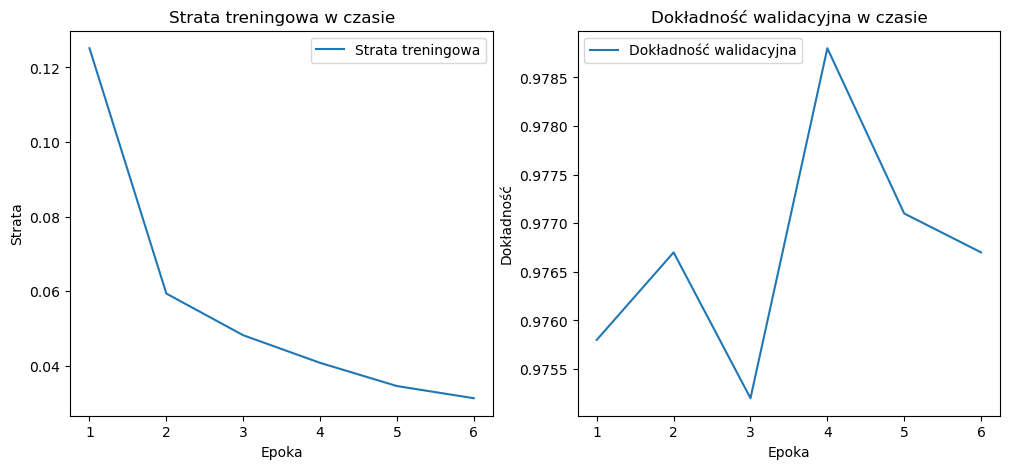

Accuracy of fine-tuned ViT on the test images: 97.39%


In [42]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import timm
from accelerate import Accelerator
import matplotlib.pyplot as plt

# Inicjalizuj accelerator
accelerator = Accelerator()

# Definiuj transformacje dla zbioru danych CIFAR-10
transform = transforms.Compose([
    transforms.Resize(224),  # Zmień rozmiar, aby dopasować do wejścia modelu
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Przygotuj zbiór danych CIFAR-10
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Podziel zbiór danych na treningowy i walidacyjny
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Funkcja do tworzenia DataLoader
def create_dataloader(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, persistent_workers=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True, persistent_workers=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True, persistent_workers=True)
    return train_loader, val_loader, test_loader

# Załaduj wstępnie wytrenowany model Vision Transformer z timm i zmodyfikuj go dla CIFAR-10
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=10)

# Zamroź początkowe warstwy
for name, param in model.named_parameters():
    if "head" not in name:  # Odblojuj tylko ostatnią warstwę
        param.requires_grad = False

# Definiuj funkcję straty i optymalizator
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

# Stwórz DataLoader'y
batch_size = 64
train_loader, val_loader, test_loader = create_dataloader(batch_size)

# Przygotuj z accelerator
model, optimizer, train_loader, val_loader, test_loader = accelerator.prepare(model, optimizer, train_loader, val_loader, test_loader)

# Funkcja do trenowania modelu z wczesnym zatrzymaniem
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, patience):
    model.train()
    train_losses = []
    val_accuracies = []
    best_val_accuracy = 0
    patience_counter = 0

    for epoch in range(epochs):
        current_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, targets = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            accelerator.backward(loss)
            optimizer.step()
            current_loss += loss.item()
        
        avg_loss = current_loss / len(train_loader)
        train_losses.append(avg_loss)
        val_acc = validate_model(model, val_loader)
        val_accuracies.append(val_acc)

        print(f'Epoch [{epoch + 1}/{epochs}] Loss: {avg_loss:.4f}, Val Accuracy: {val_acc:.4f}')

        # Wczesne zatrzymanie
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            patience_counter = 0
            # Zapisz najlepszy model
            torch.save(model.state_dict(), 'best_model_vit.pth')
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print("Early stopping")
            break

    return train_losses, val_accuracies

# Funkcja do walidacji modelu
def validate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Funkcja do testowania modelu
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Parametry treningu
epochs = 10
patience = 2  # Liczba epok do wczesnego zatrzymania, jeśli nie ma poprawy

# Ścieżka do zapisywania/wczytywania wag modelu
model_path = 'vit_cifar10.pth'

# Sprawdź, czy istnieje zapisany model
if os.path.exists(model_path):
    # Wczytaj zapisany model
    model.load_state_dict(torch.load(model_path, map_location=accelerator.device))
    print("Wczytano zapisany model.")
else:
    # Trenuj model
    train_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, epochs, patience)
    # Zapisz wagi modelu
    torch.save(model.state_dict(), model_path)
    print("Zapisano wytrenowany model.")

    # Wyświetl wykresy
    plt.figure(figsize=(12, 5))

    # Wykres strat treningowych
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Strata treningowa')
    plt.xlabel('Epoka')
    plt.ylabel('Strata')
    plt.title('Strata treningowa w czasie')
    plt.legend()

    # Wykres dokładności walidacyjnej
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Dokładność walidacyjna')
    plt.xlabel('Epoka')
    plt.ylabel('Dokładność')
    plt.title('Dokładność walidacyjna w czasie')
    plt.legend()

    plt.show()

# Oceń model
accuracy = test_model(model, test_loader)
print(f'Accuracy of fine-tuned ViT on the test images: {accuracy * 100:.2f}%')


In [43]:
# opróżnij gpu cache
torch.cuda.empty_cache()


Jak widać, model potrafił osiągnąć zaskakujące 97% dokładności na zbiorze testowym. Chociaż model ten jest bardzo duży oraz wymagający obliczeniowo (temperatury na moim mobilnym GPU przewyższały 100°C w pewnym momencie), to istnieją bardziej kompaktowe wersje ( ViT-Tiny czy też ViT-Small), które również osiągają bardzo przyzwoite wyniki przy mniejszym zużyciu pamięci i czasie obliczeń.